In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [4]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
# location, description, requirements will be dropped.
# ['country_state', 'country'] are dropped for now, will decide once location column is filled in
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]
X_text_cols = ["combined_text"]

X = df2[X_numeric_cols+X_text_cols]
y = df2[y_col]

In [5]:
##################################
##### Define hyperparameters #####
##################################

svm_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': [0.1, 1, 10]
}

In [6]:
###########################
##### Train the model #####
###########################
fbeta = make_scorer(fbeta_score, beta=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("text_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "combined_text"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", SVC(random_state=42))
])


svm_grid = GridSearchCV(
    estimator=model,
    param_grid=svm_params,
    scoring=fbeta,
    cv=5,
    n_jobs=-1,
    verbose=1
)



svm_grid.fit(X_train, y_train.ravel())
best_svm_model = svm_grid.best_estimator_
# Make predictions and print classification report
y_pred = best_svm_model.predict(X_test)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was pass

Best parameters: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3410
           1       0.89      0.90      0.90       257

    accuracy                           0.99      3667
   macro avg       0.94      0.95      0.94      3667
weighted avg       0.99      0.99      0.99      3667

F2 Score: 0.8974358974358975


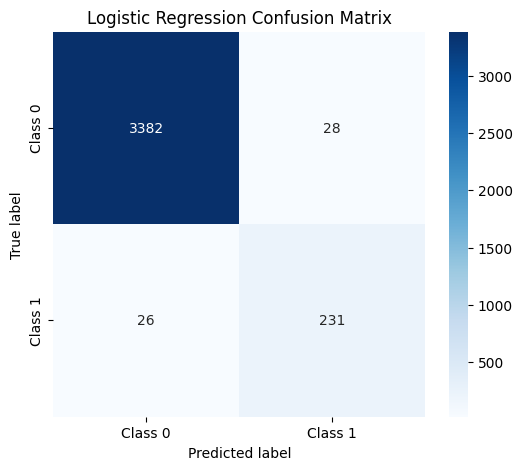

In [ ]:
###########################
##### Display results #####
###########################

print("Best parameters:", svm_grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"Logistic Regression Confusion Matrix")

In [10]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = 'models/svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svm_model, file)